In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from tensorflow import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn
from keras.layers import LeakyReLU

Using TensorFlow backend.


In [2]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "kucing_vs_anjing.h5"

# Data
path = "dataset/"
training_data_dir = path + "training" # 10 000 * 2
validation_data_dir = path + "validation" # 2 500 * 2
test_data_dir = path + "test" # 12 500

In [3]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 100
BATCH_SIZE = 32
TEST_SIZE = 30


input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)



In [4]:
model = Sequential()

# Alpha leaky relu = steepnya

model.add(Conv2D(32, kernel_size=3, strides=3, padding='same', input_shape=input_shape, activation='relu'))

model.add(Conv2D(32, kernel_size=3, strides=3, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(64, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=3, strides=3, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(256, kernel_size=3, strides=3, padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=3, strides=3, padding='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

In [5]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [6]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


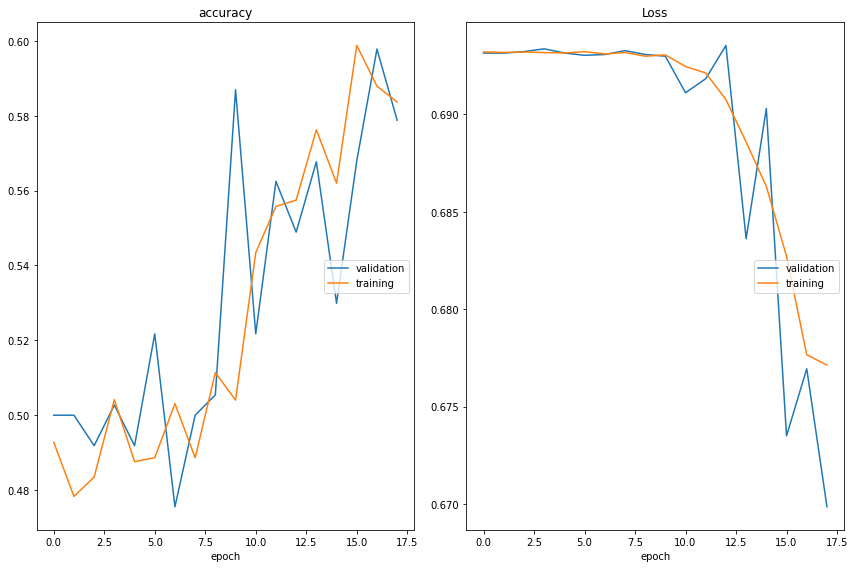

accuracy
	validation       	 (min:    0.476, max:    0.598, cur:    0.579)
	training         	 (min:    0.478, max:    0.599, cur:    0.584)
Loss
	validation       	 (min:    0.670, max:    0.694, cur:    0.670)
	training         	 (min:    0.677, max:    0.693, cur:    0.677)
Epoch 19/100
27/31 [=========================>....] - ETA: 6s - loss: 0.6602 - accuracy: 0.6389

KeyboardInterrupt: 

In [7]:
# Training
model.fit(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

model.save_weights(MODEL_FILE)

In [ ]:
# Testing
benar = 0
salah = 0
total = 0

probabilities = model.predict(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% kucing")
        benar = benar+1
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% anjing")
        salah = salah+1
    plt.show()
    total = total+1

In [ ]:
#persentase = (benar/total)*100
#print("Hasil akurasi model : %.2f" % persentase)